# Hands-On NLP — Class 3

<span style="color:magenta">Group Names:</span>

* Name 1
* Name 2
* Name 3

## Outline

- Better vectors: Tf-idf

- Ngrams

- Text generation

In [2]:
import re
import collections
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn import decomposition, naive_bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [3]:
tqdm.pandas()

nltk.download("punkt")
nltk.download("punkt_tab")

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 4)

print("sklearn's version:", sklearn.__version__)    # 1.3.2
print("nltk's version:", nltk.__version__)          # 3.8.1
print("pandas's version:", pd.__version__)          # 2.1.4

sklearn's version: 1.6.0
nltk's version: 3.9.1
pandas's version: 2.2.3


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
%config InlineBackend.figure_format="retina"  # For high DPI display

## Getting the data

In [5]:
#DATA = Path("/workspaces/Data-Scientist/NLP TP/texts")


TEXT_P = Path("/workspaces/Data-Scientist/NLP TP/texts")

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps




In [6]:
data = []

for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


In [7]:
all_df = pd.DataFrame.from_records(data, index=["id"])
all_df = all_df.drop("robotics.stackexchange_0000005103")
all_df

,text,category,cat_id
id,,,
mythology.stackexchange_0000000302,Q:\n\nWere Romulus and Remus real people?\n\nI...,mythology,0
mythology.stackexchange_0000007698,Q:\n\nHow old was Nestor?\n\nI am rereading th...,mythology,0
mythology.stackexchange_0000001333,Q:\n\nWhat is the earliest recorded example of...,mythology,0
mythology.stackexchange_0000000182,Q:\n\nWas the constellation named after the Bu...,mythology,0
mythology.stackexchange_0000010170,Q:\n\nWhat does Aphrodite’s magical girdle loo...,mythology,0
...,...,...,...
portuguese.stackexchange_0000004561,"Q:\n\nVão ou Vam, Como posso usá-los?\n\nEm um...",portuguese,5
portuguese.stackexchange_0000003362,"Q:\n\nExiste uma palavra para indicar ""anivers...",portuguese,5
portuguese.stackexchange_0000009102,"Q:\n\nSemantic difference between ""com"" and ""n...",portuguese,5


---
Here the initialization of `all_df` is done and you can jump to your favorite classification
___

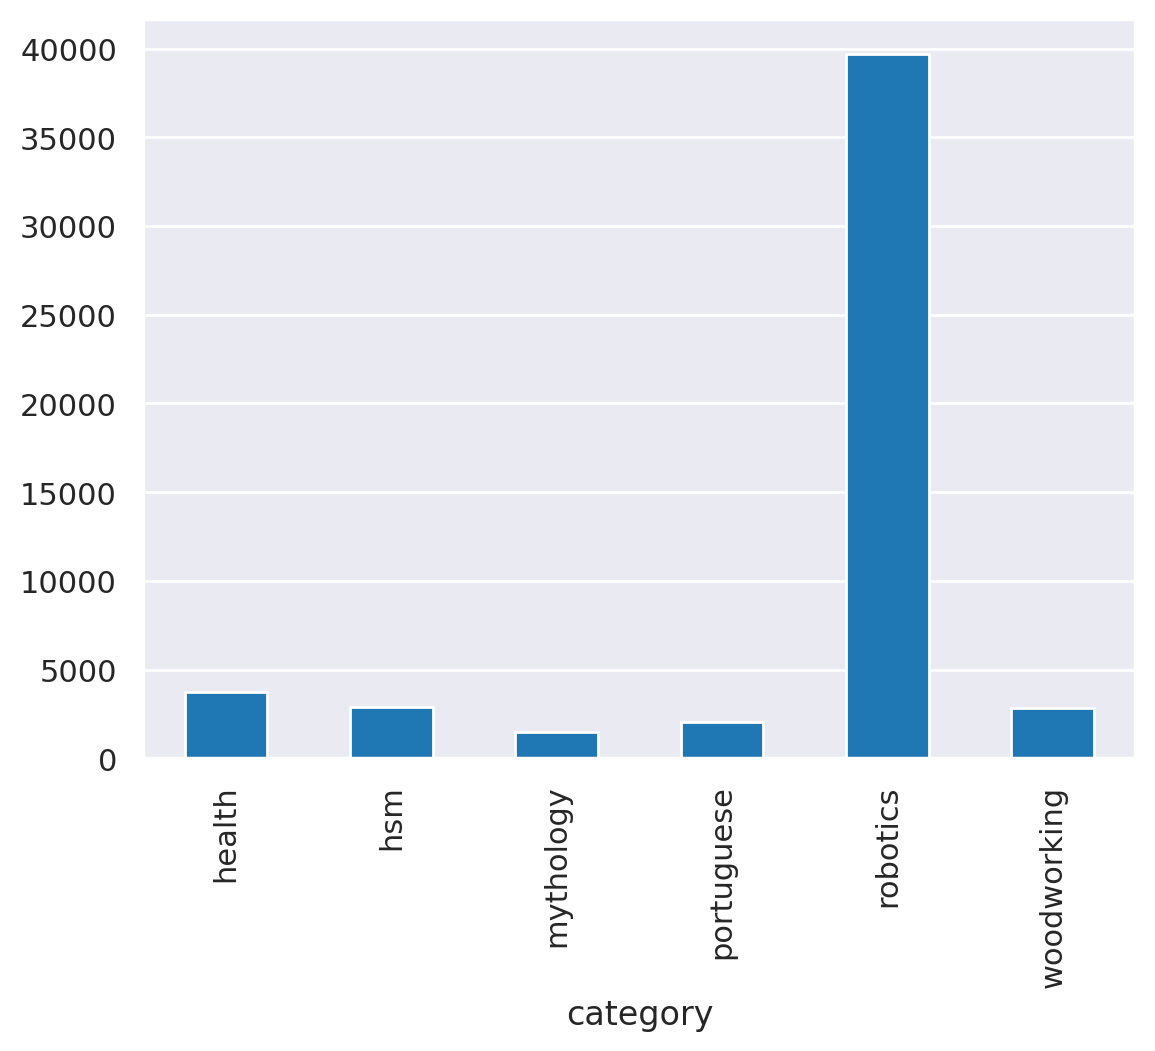

In [8]:
all_df.groupby("category").size().plot.bar()
plt.grid(axis="x")

## Vectorize

In [9]:
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

vectorizer = CountVectorizer()
xs = vectorizer.fit_transform(corpus).toarray()

cv_df = pd.DataFrame(xs, index=corpus, columns=vectorizer.get_feature_names_out())
cv_df

,and,document,first,is,one,second,the,third,this
This is the first document.,0,1,1,1,0,0,1,0,1
This document is the second document.,0,2,0,1,0,1,1,0,1
And this is the third one.,1,0,0,1,1,0,1,1,1
Is this the first document?,0,1,1,1,0,0,1,0,1


### TF-IDF

- The counting of words is not the ideal way to represent a document

- Instead of counting the number of occurences of a word, we could weight it by the number of documents it appears in

- Term Frequency - Inverse Document Frequency

#### From [Wikipedia](https://en.wikipedia.org/wiki/Tf-idf):

**Term frequency**

$$\operatorname{tf}(t,d) = \frac{f_{t,d}}{{\sum_{t' \in d}{f_{t',d}}}}$$

**Inverse document frequency**

$$\operatorname{idf}(t, D) =  - \log \frac{|\{d \in D: t \in d\}|}{N} =
    -\log \left({\frac {n_{t}}{N}}\right) $$

N: total number of documents in the corpus $N = {|D|}$

**Smoothed IDF:**

$$\operatorname{idf}(t, D) = - \log \left( \frac {1 + n_t} {N}\right)+ 1$$

#### From [scikit-learn documentation](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting):

In `TfidfVectorizer`, the implementation is slightly different:

*   For the IDF:

    *   Unsmoothed version (`smooth_idf=False`), though a $+1$ is applied to avoid a value of 0 for the IDF:
    $$\operatorname{idf}(t, D) = -\log \left({\frac {n_{t}}{N}}\right) + 1$$

    *   Smoothed version (`smooth_idf=True`):
    $$\operatorname{idf}(t, D) = - \log \left( \frac {1 + n_t} {1 + N}\right)+ 1$$

*   `TFIDF = tf(t, d) * idf(t, D)`

*   `tf(t, d)` is the **count** of the term `t` in the document `d`, not the **frequency** (**no division!**)

*   Then a global normalization is applied: `TFIDF = TFIDF / norm(TFIDF)`
    
    (instead of a normalization within `tf` only to obtain a frequency)

*   `norm` is the L2 norm by default, but can be changed to L1 or `None`.

#### 🚧 TODO: Count vs. Freq vectorizers

Compare the previous results of the `CountVectorizer` with the `TfidfVectorizer` on the same toy dataset.

In [10]:
vectorizer = TfidfVectorizer()
xs = vectorizer.fit_transform(corpus).toarray()
tf_idf = pd.DataFrame(xs, index=corpus, columns=vectorizer.get_feature_names_out())
tf_idf

,and,document,first,is,one,second,the,third,this
This is the first document.,0.0000,0.4698,0.5803,0.3841,0.0000,0.0000,0.3841,0.0000,0.3841
This document is the second document.,0.0000,0.6876,0.0000,0.2811,0.0000,0.5386,0.2811,0.0000,0.2811
And this is the third one.,0.5118,0.0000,0.0000,0.2671,0.5118,0.0000,0.2671,0.5118,0.2671
Is this the first document?,0.0000,0.4698,0.5803,0.3841,0.0000,0.0000,0.3841,0.0000,0.3841


### Let's now classify the StackOverflow documents in their respective corpus label

*   The complete corpus: `all_df`

*   Let's use the different vectorizers for representation

In [11]:
ys = all_df.cat_id.values


In [12]:
cv = CountVectorizer(max_features=5000)
xs = cv.fit_transform(all_df.text).toarray()

In [13]:
print("xs.shape =", xs.shape)
print("ys.shape =", ys.shape)

xs.shape = (52682, 5000)
ys.shape = (52682,)


In [14]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(36877, 5000)
(15805, 5000)


#### 🚧 TODO: `CountVectorizer` vs. `TfidfVectorizer` classifiers

*   Limit to the 5000 most frequent words to reduce the dimensionality

    (the sparse matrix `toarray()` method crashes if no reduction of features is applied)

*   Use both to classify the data based on, e.g., the `MultinomialNB` classifier

*   Compare their results in terms of accuracy and show their `classification_report`

In [15]:
#for countvectorizer
from sklearn.naive_bayes import MultinomialNB
def countV():
    model = MultinomialNB()
    model.fit(train_xs, train_ys)

    train_ys_pred = model.predict(train_xs)
    test_ys_pred = model.predict(test_xs)


    print("Test accuracy:", accuracy_score(test_ys, test_ys_pred))

    #classification report
    print(classification_report(test_ys, test_ys_pred))
    return model

countV()

Test accuracy: 0.9681113571654539
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       433
           1       0.81      1.00      0.89       879
           2       1.00      0.97      0.98     11887
           3       0.84      0.96      0.89       853
           4       0.93      0.98      0.95      1117
           5       1.00      0.91      0.95       636

    accuracy                           0.97     15805
   macro avg       0.91      0.97      0.93     15805
weighted avg       0.97      0.97      0.97     15805



MultinomialNB()

In [16]:
# for tfidf
td_idf = TfidfVectorizer(max_features=5000)
xs_2 = td_idf.fit_transform(all_df.text).toarray()
train_xs_2, test_xs_2, train_ys_2, test_ys_2 = train_test_split(
        xs_2, ys, test_size=0.3, random_state=0, shuffle=True
    )
def tfidf():
   
    model_1 = MultinomialNB()
    model_1.fit(train_xs_2, train_ys_2)


    test_ys_pred_2 = model_1.predict(test_xs_2)


    print("Test accuracy:", accuracy_score(test_ys_2, test_ys_pred_2))

    #classification report
    print(classification_report(test_ys_2, test_ys_pred_2))
    return model_1

tfidf()

Test accuracy: 0.9851312875672256
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       433
           1       0.91      1.00      0.95       879
           2       1.00      0.99      0.99     11887
           3       0.92      0.96      0.94       853
           4       0.96      0.98      0.97      1117
           5       1.00      0.94      0.97       636

    accuracy                           0.99     15805
   macro avg       0.96      0.97      0.96     15805
weighted avg       0.99      0.99      0.99     15805



MultinomialNB()

In [17]:
#comparing the results

def compare():
    model = countV()
    model_1 = tfidf()
    print("CountVectorizer accuracy:", accuracy_score(test_ys, model.predict(test_xs)))
    print("TfidfVectorizer accuracy:", accuracy_score(test_ys_2, model_1.predict(test_xs_2)))
    
    return model, model_1

compare()

Test accuracy: 0.9681113571654539
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       433
           1       0.81      1.00      0.89       879
           2       1.00      0.97      0.98     11887
           3       0.84      0.96      0.89       853
           4       0.93      0.98      0.95      1117
           5       1.00      0.91      0.95       636

    accuracy                           0.97     15805
   macro avg       0.91      0.97      0.93     15805
weighted avg       0.97      0.97      0.97     15805

Test accuracy: 0.9851312875672256
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       433
           1       0.91      1.00      0.95       879
           2       1.00      0.99      0.99     11887
           3       0.92      0.96      0.94       853
           4       0.96      0.98      0.97      1117
           5       1.00      0.94      0.97       636

    accur

(MultinomialNB(), MultinomialNB())

#### 🚧 TODO: `MultinomialNB` vs. `GaussianNB` classifiers

*   Use both to classify the data

*   Compare their results in terms of accuracy and show their `classification_report`

In [1]:
#multinomialNB vs GaussianNB
from sklearn.naive_bayes import GaussianNB
model_2 = GaussianNB()
model_2.fit(train_xs_2, train_ys_2)

  
test_ys_pred_2 = model_2.predict(test_xs_2)



print("Test accuracy:", accuracy_score(test_ys_2, test_ys_pred_2))

#classification report
print(classification_report(test_ys_2, test_ys_pred_2))




NameError: name 'train_xs_2' is not defined

#### 🚧 TODO: Confusion matrix for the MultinomialNB classifier

- Translate this result into a sentence

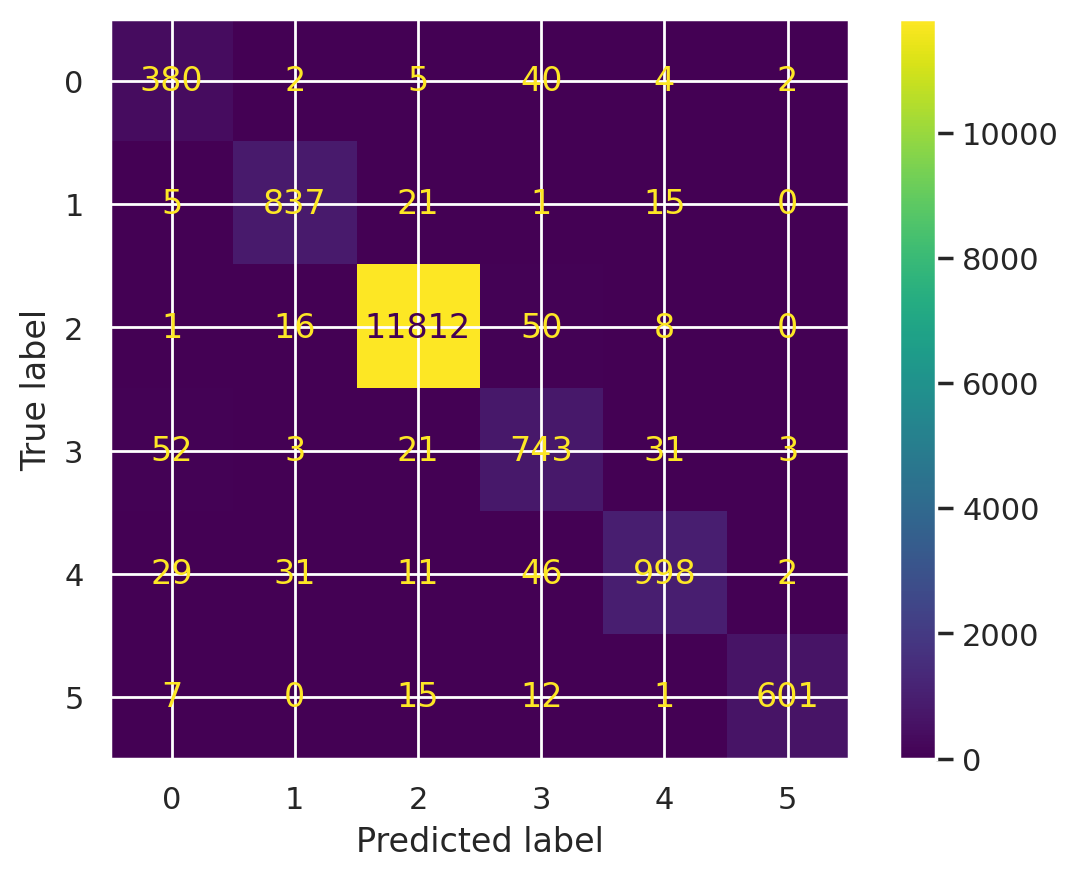

In [17]:
#confusion matrix on MultinomialNB

cm = confusion_matrix(test_ys, test_ys_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(6))

disp.plot()
plt.show()


#### 🚧 TODO: add the `stop_words="english"` option to the `tf_idf` vectorizer

*   Compare the size of the `sparse_xs` for the 2 conditions (stop words included or not)

*   Retrain with the new vectorizer and the MultinomialNB classifier

*   Compare the results with the previous vectorizer

#### 🚧 TODO: PCA

*   Apply PCA to project on 2 dimensions to all vectors (train and test) and plot them

*   Compare the plot with the previous vectorizer with, and without the `stop_words="english"` option

*   Explain the difference breafly

#### 🚧 TODO: Train on PCA

*   Apply PCA to project on 2 dimensions to all vectors (train and test), fitting the PCA only on the training set

*   Train the MultinomialNB and the GaussianNB classifiers on the PCA vectors

    Does it work with both classifiers? Explain breafly.

*   Compare the results with the vectorizer with, and without, the `stop_words="english"` option

*   Analyze the difference breafly

#### 🚧 TODO: PCA with more dimensions

*   Try to find the best number of dimensions for the PCA with [`GridSearchCV`](sklearn.model_selection.GridSearchCV)

*   Use pipeline to combine the PCA and the classifier and other potential preprocessing steps

*   Boxplot accuracyies for different PCA dimension values using [`GridSearchCV`](sklearn.model_selection.GridSearchCV)

## N-grams features for text classification

*   We will use bigram in this section

In [18]:
vectorizer_2g = CountVectorizer(
    analyzer="word", ngram_range=(2, 2), max_features=5000,
)
x2gs = vectorizer_2g.fit_transform(all_df.text).toarray()

In [19]:
pd.DataFrame(vectorizer_2g.get_feature_names_out(), columns=["bigrams"])

,bigrams
0,00 00
1,000 000
2,000000 000000
3,001 001
4,01 01
...,...
4995,your system
4996,your time
4997,your urdf
4998,your workspace


In [20]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    x2gs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(36877, 5000)
(15805, 5000)


#### 🚧 TODO: Train classification models on n-grams

*   Train on the `CountVectorizer` with bigrams using the `MultinomialNB` classifier

*   Compare the results with the previous "raw" `CountVectorizer`

---
## Building an n-gram generator
___

### Let's build character trigrams first

In [21]:
LINE = "This is cool!"
N = 3
[LINE[i : i + N] for i in range(len(LINE) - N + 1)]

['Thi', 'his', 'is ', 's i', ' is', 'is ', 's c', ' co', 'coo', 'ool', 'ol!']

In [22]:
[tuple(LINE[i : i + N]) for i in range(len(LINE) - N + 1)]

[('T', 'h', 'i'),
 ('h', 'i', 's'),
 ('i', 's', ' '),
 ('s', ' ', 'i'),
 (' ', 'i', 's'),
 ('i', 's', ' '),
 ('s', ' ', 'c'),
 (' ', 'c', 'o'),
 ('c', 'o', 'o'),
 ('o', 'o', 'l'),
 ('o', 'l', '!')]

In [23]:
LINES = """This is cool!
This is amazing!
But why is this his fish?"""

re.split("\n+", LINES.lower())

['this is cool!', 'this is amazing!', 'but why is this his fish?']

In [24]:
ngrams = collections.Counter()

for line in re.split("\n+", LINES.lower()):
    ngrams.update([line[i : i + N] for i in range(len(line) - N + 1)])

nc_df = pd.DataFrame.from_dict(
    ngrams, orient="index", columns=["freq"]
).sort_values("freq", ascending=False)

nc_df.head(7)

,freq
is,7
his,4
thi,3
is,3
s i,2
s c,1
co,1


### Back to our corpora

#### 🚧 TODO: Build an ngram generator for the `"woodworking"` corpus

*   Tokenize the corpus first with `nltk.word_tokenize`

*   Normalize the tokens by simply simply lowercasing them

*   Give the tokens frequency to the ngram generator

In [25]:
wood_df = all_df[all_df.category == "woodworking"]
wood_df.head()

,text,category,cat_id
id,,,
woodworking.stackexchange_0000005606,"Q:\n\nHow to cut and join ""wedges"" of plywood ...",woodworking,1
woodworking.stackexchange_0000000346,Q:\n\nHow can I tell if my green wood is dry e...,woodworking,1
woodworking.stackexchange_0000006451,Q:\n\nWalnut drawer sides: Is it wise to glue-...,woodworking,1
woodworking.stackexchange_0000009881,Q:\n\nCan I remove existing wood finishes usin...,woodworking,1
woodworking.stackexchange_0000011386,Q:\n\nCan you store a synthetic waterstone in ...,woodworking,1


In [26]:
wood_txt = wood_df.iloc[0].text
print(wood_txt[:333])

Q:

How to cut and join "wedges" of plywood to form a perfect circle

My wife wants a new dining room table -- a round one of about 4.5' in diameter.
I am constructing it out of rift sawn white oak. I will be using 3/4" ply for the table top (MDF core) and then laminate bending white oak around the edge (circumference), possibly wi


#### 🚧 TODO: Text generation with ngrams

*   Generate a text of words until a stop word is generated (`.`)

*   Assign a probability to each ngrams based on their frequency

*   Sample from the ngrams based on their probability

*   Try different starting words (use bigrams)

 *Note:* [`default_rng`](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng) is the recommended constructor for random number generation in NumPy.

### TODO (optional): Improve this algorithm

- Try to fix some possible issues, by handeling exceptions

- Improve the output spacing (no space before comma, etc.) and maybe handle the upper case

- Try on a different domain of our corpus

---